# 파일 읽기

In [29]:
# Standard library
import warnings
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd

# Statistics & modeling
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    VotingRegressor
)
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
    GroupKFold,
    TimeSeriesSplit
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    RobustScaler,
    StandardScaler,
    MinMaxScaler
)
from lightgbm import LGBMRegressor  # pip install lightgbm
from xgboost import XGBRegressor

# Visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')


In [30]:
import matplotlib.font_manager as fm

paths = fm.findSystemFonts(fontpaths=None, fontext='ttf')
nanum_fonts = [p for p in paths if 'Nanum' in p]  # 'NanumGothic' 대신 'Nanum' 으로 검색
print("찾은 나눔 폰트:")
for p in nanum_fonts:
    print(" ", p)

찾은 나눔 폰트:
  C:\Windows\Fonts\NanumBarunpenR.ttf
  C:\Windows\Fonts\NanumSquareR.ttf


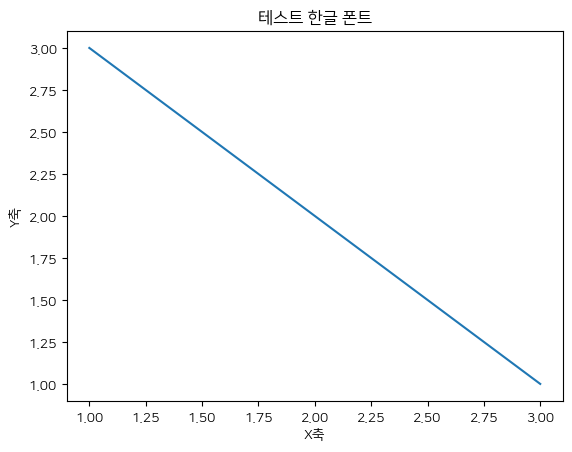

In [31]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  # 이 줄 추가!

# 1) 경로 지정 (공백 삭제)
nanum_path = r"C:/Windows/Fonts/NanumSquareR.ttf"

# 2) 폰트 등록
fm.fontManager.addfont(nanum_path)

# 3) 실제 폰트 이름 추출
prop = FontProperties(fname=nanum_path)
font_name = prop.get_name()

# 4) rcParams에 반영
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 5) 테스트 플롯
plt.plot([1,2,3], [3,2,1])
plt.title("테스트 한글 폰트")
plt.xlabel("X축")
plt.ylabel("Y축")
plt.show()


In [32]:
# 파일 읽기
input_path = Path(r"C:/Users/user/OneDrive/Desktop/최강이세용/fatigue_df_속도처리.csv")
output_path = input_path.parent / '피로도지수_df.csv'
df = pd.read_csv(input_path)
df.head()

,Name,Year,Team,Date,Role,ERA,WHIP,IP,NP,R,...,Total_IP,직구_피안타율,직구_구사율,변화구_구사율,이동거리,누적이동거리,속도,avg_FIP,avg_속도,Δ속도
0,고영표,2021,KT,2021-04-07,SP,1.50,0.83,6.0,88,1,...,166.666667,0.254,28.0,72.0,0,0,134.8,3.155769,137.356522,-2.556522
1,고영표,2021,KT,2021-04-13,SP,4.50,1.17,6.0,95,3,...,166.666667,0.254,28.0,72.0,294,570,136.1,3.155769,137.356522,-1.256522
2,고영표,2021,KT,2021-04-18,SP,3.00,0.83,6.0,91,2,...,166.666667,0.254,28.0,72.0,0,601,137.3,3.155769,137.356522,-0.056522
3,고영표,2021,KT,2021-04-24,SP,4.50,1.83,6.0,86,3,...,166.666667,0.254,28.0,72.0,0,1261,136.3,3.155769,137.356522,-1.056522
4,고영표,2021,KT,2021-04-30,SP,3.86,1.14,7.0,97,3,...,166.666667,0.254,28.0,72.0,39,1339,136.5,3.155769,137.356522,-0.856522


# 1차 모델링

## df_SP

In [33]:
df_sp = df[df['Role'] == 'SP']
df_rp = df[df['Role'] == 'RP']

In [34]:
# 주요 수치형 변수 요약 통계
df_sp[['NP', 'IP',
    '연투 여부', '연투일', '연투수', '휴식일 수',
    '직구_구사율', '변화구_구사율','Δ속도']].describe()


,NP,IP,연투일,연투수,휴식일 수,직구_구사율,변화구_구사율,Δ속도
count,3507.000000,3507.000000,3507.000000,3507.000000,3507.000000,3507.000000,3507.000000,3457.000000
mean,87.249501,5.136869,1.000285,0.368121,6.330767,44.877531,55.122469,-0.183484
std,16.175262,1.431284,0.016886,1.304229,6.703362,10.052916,10.052916,1.465317
min,11.000000,0.333333,1.000000,0.000000,0.000000,0.200000,32.000000,-7.700000
25%,80.000000,4.333333,1.000000,0.000000,5.000000,40.700000,48.300000,-1.097436
50%,91.000000,5.000000,1.000000,0.000000,5.000000,46.100000,53.900000,-0.111538
75%,98.000000,6.000000,1.000000,0.000000,6.000000,51.700000,59.300000,0.783871
max,123.000000,9.000000,2.000000,14.000000,103.000000,68.000000,99.800000,4.885714


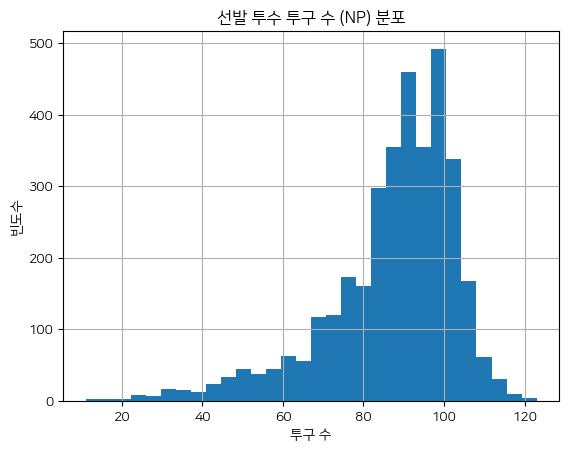

In [35]:
import matplotlib.pyplot as plt

df_sp['NP'].hist(bins=30)
plt.title('선발 투수 투구 수 (NP) 분포')
plt.xlabel('투구 수')
plt.ylabel('빈도수')
plt.grid(True)
plt.show()


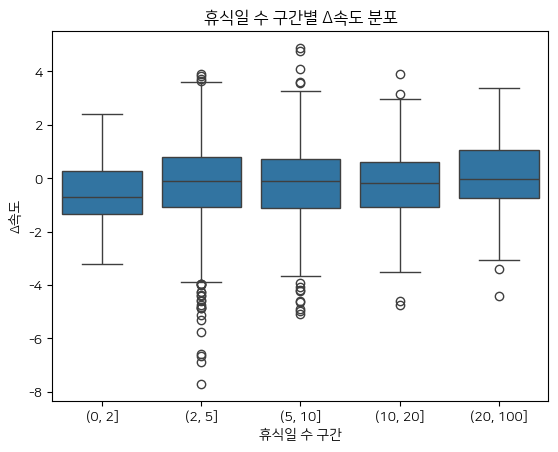

In [36]:
import seaborn as sns

sns.boxplot(x=pd.cut(df_sp['휴식일 수'], bins=[0,2,5,10,20,100]), y='Δ속도', data=df_sp)
plt.title('휴식일 수 구간별 Δ속도 분포')
plt.xlabel('휴식일 수 구간')
plt.ylabel('Δ속도')
plt.show()


In [37]:
# Workload 변수 선택
workload_feats = [
    'NP', 'IP',
    '연투 여부', '연투일', '연투수', '휴식일 수',
    '직구_구사율', '변화구_구사율'
]
X_raw = df[workload_feats]
y = df['Δ속도']

# 컬럼별 스케일러 정의
preprocessor = ColumnTransformer([
    ('robust', RobustScaler(),    ['NP','IP']),
    ('std',    StandardScaler(),  ['연투일','연투수','휴식일 수']),
    ('minmax', MinMaxScaler(),    ['직구_구사율','변화구_구사율']),
    ('passth', 'passthrough',     ['연투 여부']),
])

X_scaled = preprocessor.fit_transform(X_raw)
scaled_columns = workload_feats
X_scaled_df = pd.DataFrame(X_scaled, columns=scaled_columns)

In [38]:
df_sp['혹사지수'] = (
    df_sp['연투 여부'].astype(int) * 5 + 
    df_sp['연투일'] * 2 - 
    df_sp['휴식일 수']
)

In [39]:
cols = ['NP', 'IP', '직구_구사율', '혹사지수']
df_model = df_sp[cols + ['GSv2']].dropna()

X = df_model[cols]
y = df_model['GSv2']

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"📊 RandomForestRegressor 결과")
print(f"R² score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

📊 RandomForestRegressor 결과
R² score: 0.9723
RMSE: 2.1161


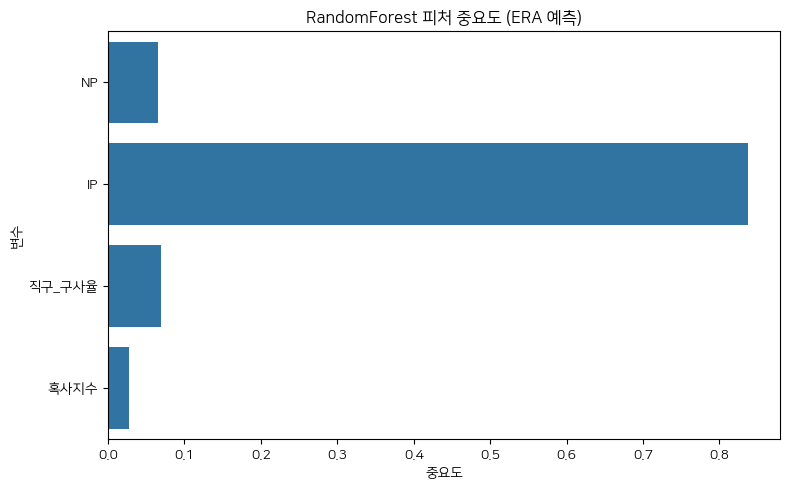

📊 Feature Importance (수치):
IP        0.837454
직구_구사율    0.069906
NP        0.065555
혹사지수      0.027085
dtype: float64


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 피처 중요도 계산
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# 중요도 내림차순 정렬 + 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("RandomForest 피처 중요도 (ERA 예측)")
plt.xlabel("중요도")
plt.ylabel("변수")
plt.tight_layout()
plt.show()

# 수치 출력
print("📊 Feature Importance (수치):")
print(feature_importances.sort_values(ascending=False))

In [41]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
import shap
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# 1. 피로 변수 + 스케일링
fatigue_feats = ['NP', 'IP', '직구_구사율', '혹사지수']
df_model = df_sp[fatigue_feats + ['GSv2']].dropna().copy()

scaler = MinMaxScaler()
X_scaled_array = scaler.fit_transform(df_model[fatigue_feats])
X_scaled = pd.DataFrame(X_scaled_array, columns=fatigue_feats, index=df_model.index)

# 2. 선형 회귀 학습
model = LinearRegression()
model.fit(X_scaled, df_model['GSv2'])

# 3. SHAP 적용
explainer = shap.Explainer(model, X_scaled)
shap_values = explainer(X_scaled)

In [43]:
shap_values

.values =
array([[ 2.41886497e-01,  8.94999554e+00, -6.83842788e-02,
         1.01150091e-02],
       [-1.13470333e+00,  8.94999554e+00, -6.83842788e-02,
         3.37166970e-03],
       [-3.48080569e-01,  8.94999554e+00, -6.83842788e-02,
         4.72033757e-03],
       ...,
       [-1.52801470e+00,  2.17815304e+01,  3.02987842e-02,
         4.72033757e-03],
       [-1.51424881e-01,  1.85736467e+01,  3.02987842e-02,
         3.37166970e-03],
       [ 2.41886497e-01,  8.94999554e+00,  3.02987842e-02,
         6.74333939e-04]], shape=(3507, 4))

.base_values =
array([60.95904869, 60.95904869, 60.95904869, ..., 60.95904869,
       60.95904869, 60.95904869], shape=(3507,))

.data =
array([[0.6875    , 0.65384615, 0.4100295 , 0.93636364],
       [0.75      , 0.65384615, 0.4100295 , 0.89090909],
       [0.71428571, 0.65384615, 0.4100295 , 0.9       ],
       ...,
       [0.76785714, 0.80769231, 0.78761062, 0.9       ],
       [0.70535714, 0.76923077, 0.78761062, 0.89090909],
       [0.6875 

In [44]:
# mean absolute SHAP 값 → 가중치 정규화
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_weights = mean_abs_shap / mean_abs_shap.sum()

# 확인
for feat, w in zip(fatigue_feats, shap_weights):
    print(f"{feat}: {w:.4f}")

NP: 0.1807
IP: 0.8167
직구_구사율: 0.0022
혹사지수: 0.0004


In [45]:
from sklearn.preprocessing import MinMaxScaler

# 사용할 피로 변수와 SHAP 가중치 기반 변수 리스트
fatigue_feats = ['NP', 'IP', '직구_구사율', '혹사지수']

# 결측치 제거
df_valid = df_sp[fatigue_feats].dropna()

# MinMax 스케일링
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(df_valid)
scaled_df = pd.DataFrame(scaled_array, columns=fatigue_feats, index=df_valid.index)

In [46]:
# SHAP 기반 수식 점수
df_sp['Fatigue_Score_shap'] = 0
for i, col in enumerate(fatigue_feats):
    df_sp.loc[scaled_df.index, 'Fatigue_Score_shap'] += scaled_df[col] * shap_weights[i]

In [47]:
df_sp['Fatigue_Score_shap']

0        0.659507
1        0.670786
2        0.664335
3        0.656263
4        0.768252
           ...   
17523    0.775525
17524    0.558850
17525    0.800483
17526    0.757771
17527    0.660298
Name: Fatigue_Score_shap, Length: 3507, dtype: float64

### R-squared

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = df_sp[['Fatigue_Score_shap']].dropna()
y = df_sp.loc[X.index, 'GSv2']

model = LinearRegression().fit(X, y)
print(f"R² score: {model.score(X, y):.4f}")

R² score: 0.7637


In [49]:
from scipy.stats import pearsonr

# 결측치 제거
df_corr = df_sp[['Fatigue_Score_shap', 'GSv2']].dropna()
x = df_corr['Fatigue_Score_shap']
y = df_corr['GSv2']

# 피어슨 상관계수
corr, p_val = pearsonr(x, y)

print(f"📊 Pearson r: {corr:.4f}")
print(f"📉 p-value: {p_val:.4e}")

📊 Pearson r: 0.8739
📉 p-value: 0.0000e+00


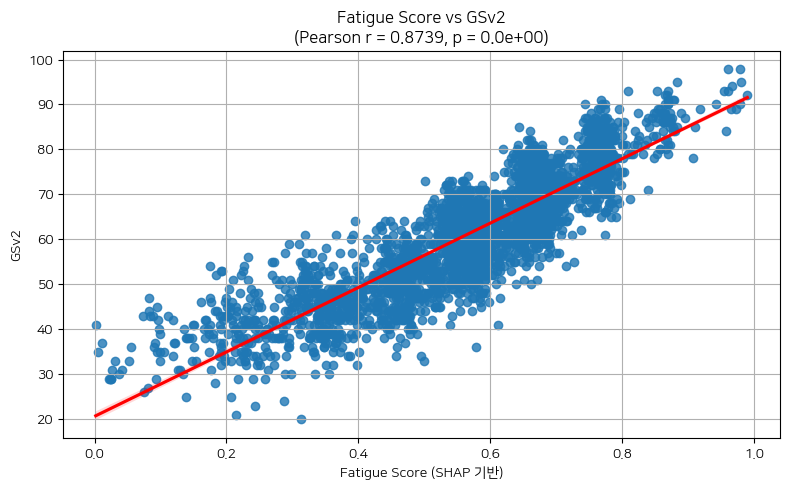

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# 산점도 + 회귀선 시각화
plt.figure(figsize=(8, 5))
sns.regplot(x='Fatigue_Score_shap', y='GSv2', data=df_corr, line_kws={"color": "red"})
plt.title(f"Fatigue Score vs GSv2\n(Pearson r = {corr:.4f}, p = {p_val:.1e})")
plt.xlabel("Fatigue Score (SHAP 기반)")
plt.ylabel("GSv2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
from sklearn.linear_model import Ridge

ridge = Ridge()

# y는 df_model과 같은 인덱스에서 df_sp['GSv2'] 가져오기
y = df_sp.loc[df_model.index, 'GSv2']

ridge.fit(X_scaled, y)

print("R²:", ridge.score(X_scaled, y))
print("계수:", dict(zip(fatigue_feats, ridge.coef_)))

R²: 0.8369483774944728
계수: {'NP': np.float64(-19.887072696305655), 'IP': np.float64(81.16577445829802), '직구_구사율': np.float64(0.12078727262730851), '혹사지수': np.float64(0.09834949092941653)}


## df_RP

In [56]:
df_rp['혹사지수'] = (
    df_rp['연투 여부'].astype(int) * 5 + 
    df_rp['연투일'] * 2 - 
    df_rp['휴식일 수']
)

In [ ]:
import shap
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# 1. 피로 변수 + 스케일링
fatigue_feats = ['NP', 'IP', '직구_구사율', '혹사지수']
df_model2 = df_rp[fatigue_feats + ['GSv2']].dropna().copy()

scaler = MinMaxScaler()
X_scaled_array = scaler.fit_transform(df_model2[fatigue_feats])
X_scaled = pd.DataFrame(X_scaled_array, columns=fatigue_feats, index=df_model2.index)

# 2. 선형 회귀 학습
model = LinearRegression()
model.fit(X_scaled, df_model2['GSv2'])

# 3. SHAP 적용
explainer = shap.Explainer(model, X_scaled)
shap_values2 = explainer(X_scaled)

In [66]:
shap_values2

.values =
array([[-6.67416539e+00,  1.86348773e+01, -4.27224577e-02,
         6.56415070e-04],
       [ 2.39907025e+00, -3.25172355e+00, -4.80615290e-02,
         5.70576176e-03],
       [-8.27532462e+00,  3.73948208e+01, -1.76090482e-02,
        -2.45903184e-02],
       ...,
       [-8.54218449e+00,  1.23815628e+01,  1.34366628e-02,
         6.56415070e-04],
       [ 4.00022947e+00, -6.37838082e+00,  1.34366628e-02,
        -9.44227831e-03],
       [ 4.26708935e+00, -6.37838082e+00,  1.34366628e-02,
        -1.44916250e-02]], shape=(14021, 4))

.base_values =
array([44.62652899, 44.62652899, 44.62652899, ..., 44.62652899,
       44.62652899, 44.62652899], shape=(14021,))

.data =
array([[0.44210526, 0.42105263, 0.36710526, 0.90551181],
       [0.08421053, 0.05263158, 0.33157895, 0.91338583],
       [0.50526316, 0.73684211, 0.53421053, 0.86614173],
       ...,
       [0.51578947, 0.31578947, 0.74078947, 0.90551181],
       [0.02105263, 0.        , 0.74078947, 0.88976378],
       [0.010

In [72]:
# mean absolute SHAP 값 → 가중치 정규화
mean_abs_shap2 = np.abs(shap_values2.values).mean(axis=0)
shap_weights2 = mean_abs_shap2 / mean_abs_shap2.sum()

# 확인
for feat, w in zip(fatigue_feats, shap_weights2):
    print(f"{feat}: {w:.4f}")

NP: 0.3783
IP: 0.6139
직구_구사율: 0.0038
혹사지수: 0.0039


In [79]:
from sklearn.preprocessing import MinMaxScaler

# 사용할 피로 변수와 SHAP 가중치 기반 변수 리스트
fatigue_feats = ['NP', 'IP', '직구_구사율', '혹사지수']

# 결측치 제거
df_valid = df_rp[fatigue_feats].dropna()

# MinMax 스케일링
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(df_valid)
scaled_df_rp = pd.DataFrame(scaled_array, columns=fatigue_feats, index=df_valid.index)

In [80]:
# SHAP 기반 수식 점수
df_rp['Fatigue_Score_shap2'] = 0
for i, col in enumerate(fatigue_feats):
    df_rp.loc[scaled_df_rp.index, 'Fatigue_Score_shap2'] += scaled_df_rp[col] * shap_weights2[i]

In [81]:
df_rp['Fatigue_Score_shap2']

25       0.430720
54       0.069038
99       0.648960
100      0.125752
101      0.141620
           ...   
17463    0.146660
17464    0.154904
17465    0.395407
17466    0.014306
17467    0.010293
Name: Fatigue_Score_shap2, Length: 14021, dtype: float64

In [84]:
from scipy.stats import pearsonr

# 결측치 제거
df_corr2 = df_rp[['Fatigue_Score_shap2', 'GSv2']].dropna()
x = df_corr2['Fatigue_Score_shap2']
y = df_corr2['GSv2']

# 피어슨 상관계수
corr, p_val = pearsonr(x, y)

print(f"📊 Pearson r: {corr:.4f}")
print(f"📉 p-value: {p_val:.4e}")

📊 Pearson r: 0.5763
📉 p-value: 0.0000e+00


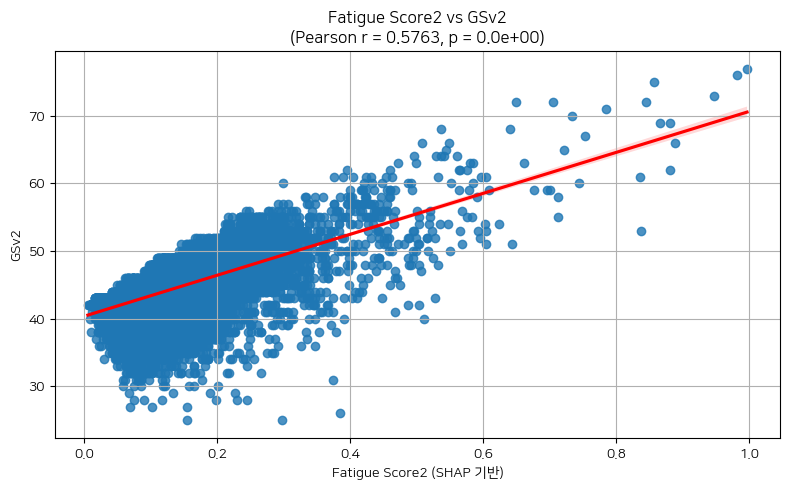

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# 산점도 + 회귀선 시각화
plt.figure(figsize=(8, 5))
sns.regplot(x='Fatigue_Score_shap2', y='GSv2', data=df_corr2, line_kws={"color": "red"})
plt.title(f"Fatigue Score2 vs GSv2\n(Pearson r = {corr:.4f}, p = {p_val:.1e})")
plt.xlabel("Fatigue Score2 (SHAP 기반)")
plt.ylabel("GSv2")
plt.grid(True)
plt.tight_layout()
plt.show()

## ERA

In [87]:
import shap
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# 1. 피로 변수 + 스케일링
fatigue_feats = ['NP', 'IP', '직구_구사율', '혹사지수']
df_model4 = df_rp[fatigue_feats + ['ERA']].dropna().copy()

scaler = MinMaxScaler()
X_scaled_array = scaler.fit_transform(df_model2[fatigue_feats])
X_scaled = pd.DataFrame(X_scaled_array, columns=fatigue_feats, index=df_model2.index)

# 2. 선형 회귀 학습
model = LinearRegression()
model.fit(X_scaled, df_model4['ERA'])

# 3. SHAP 적용
explainer = shap.Explainer(model, X_scaled)
shap_values4 = explainer(X_scaled)

In [88]:
shap_values4

.values =
array([[ 2.06965061e+01, -3.26717114e+01,  2.92504719e-01,
        -1.16511034e-03],
       [-7.43948780e+00,  5.70110399e+00,  3.29059347e-01,
        -1.01274976e-02],
       [ 2.56616815e+01, -6.55626959e+01,  1.20562579e-01,
         4.36468260e-02],
       ...,
       [ 2.64892107e+01, -2.17080498e+01, -9.19958141e-02,
        -1.16511034e-03],
       [-1.24046632e+01,  1.11829348e+01, -9.19958141e-02,
         1.67596642e-02],
       [-1.32321924e+01,  1.11829348e+01, -9.19958141e-02,
         2.57220514e-02]], shape=(14021, 4))

.base_values =
array([5.23388905, 5.23388905, 5.23388905, ..., 5.23388905, 5.23388905,
       5.23388905], shape=(14021,))

.data =
array([[0.44210526, 0.42105263, 0.36710526, 0.90551181],
       [0.08421053, 0.05263158, 0.33157895, 0.91338583],
       [0.50526316, 0.73684211, 0.53421053, 0.86614173],
       ...,
       [0.51578947, 0.31578947, 0.74078947, 0.90551181],
       [0.02105263, 0.        , 0.74078947, 0.88976378],
       [0.01052632,

In [89]:
# mean absolute SHAP 값 → 가중치 정규화
mean_abs_shap4 = np.abs(shap_values4.values).mean(axis=0)
shap_weights4 = mean_abs_shap4 / mean_abs_shap4.sum()

# 확인
for feat, w in zip(fatigue_feats, shap_weights4):
    print(f"{feat}: {w:.4f}")

NP: 0.5140
IP: 0.4715
직구_구사율: 0.0115
혹사지수: 0.0031


In [90]:
from sklearn.preprocessing import MinMaxScaler

# 사용할 피로 변수와 SHAP 가중치 기반 변수 리스트
fatigue_feats = ['NP', 'IP', '직구_구사율', '혹사지수']

# 결측치 제거
df_valid = df_rp[fatigue_feats].dropna()

# MinMax 스케일링
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(df_valid)
scaled_df_rp = pd.DataFrame(scaled_array, columns=fatigue_feats, index=df_valid.index)

In [91]:
# SHAP 기반 수식 점수
df_rp['Fatigue_Score_shap4'] = 0
for i, col in enumerate(fatigue_feats):
    df_rp.loc[scaled_df_rp.index, 'Fatigue_Score_shap4'] += scaled_df_rp[col] * shap_weights4[i]

In [92]:
df_rp['Fatigue_Score_shap4']

25       0.432737
54       0.074701
99       0.615890
100      0.133503
101      0.155095
           ...   
17463    0.163678
17464    0.174715
17465    0.425267
17466    0.022051
17467    0.016617
Name: Fatigue_Score_shap4, Length: 14021, dtype: float64

In [97]:
from scipy.stats import pearsonr

# 결측치 제거
df_corr4 = df_rp[['Fatigue_Score_shap4', 'ERA']].dropna()
x = df_corr4['Fatigue_Score_shap4']
y = df_corr4['ERA']

# 피어슨 상관계수
corr, p_val = pearsonr(x, y)

print(f"📊 Pearson r: {corr:.4f}")
print(f"📉 p-value: {p_val:.4e}")

📊 Pearson r: -0.0443
📉 p-value: 1.5826e-07


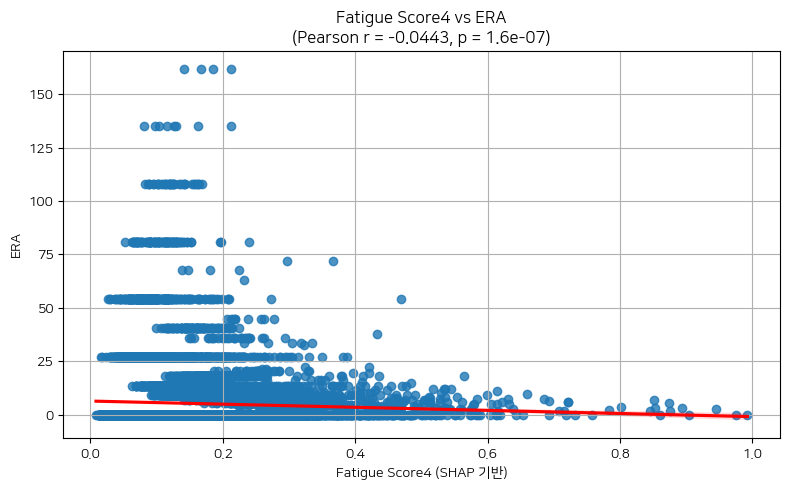

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# 산점도 + 회귀선 시각화
plt.figure(figsize=(8, 5))
sns.regplot(x='Fatigue_Score_shap4', y='ERA', data=df_corr4, line_kws={"color": "red"})
plt.title(f"Fatigue Score4 vs ERA\n(Pearson r = {corr:.4f}, p = {p_val:.1e})")
plt.xlabel("Fatigue Score4 (SHAP 기반)")
plt.ylabel("ERA")
plt.grid(True)
plt.tight_layout()
plt.show()